In [1]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, RepeatVector

In [2]:
ELC = pd.read_csv('/content/ELC.csv', sep=";")
ELC = ELC.dropna()  # Xóa các giá trị bị thiếu
ELC = ELC.reset_index(drop=True)  # Đặt lại chỉ mục

ELC

,Date,Price,High,Low
0,15/12/2016,20446.0,20667.4,19929.3
1,16/12/2016,20298.3,20667.4,19929.3
2,19/12/2016,20298.3,20409.1,20150.7
3,20/12/2016,20076.9,20298.3,19929.3
4,21/12/2016,19855.5,20372.1,19560.2
...,...,...,...,...
1744,11/12/2023,19350.0,19800.0,19250.0
1745,12/12/2023,19350.0,19550.0,19100.0
1746,13/12/2023,18900.0,19400.0,18800.0
1747,14/12/2023,19150.0,19400.0,18850.0


In [3]:
# Xử lý dữ liệu
prices = ELC['Price']

In [4]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

# 7:3


In [5]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.7)
test_size = int(len(scaled_prices) * 0.3)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [6]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(FPT, time_steps):
    X, y = [], []
    for i in range(len(FPT) - time_steps):
        X.append(FPT[i:i+time_steps])
        y.append(FPT[i+time_steps])
    return np.array(X), np.array(y)

In [7]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
19/19 [==============================] - 6s 21ms/step - loss: 0.0295
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0021
Epoch 3/100
19/19 [==============================] - 0s 24ms/step - loss: 4.8189e-04
Epoch 4/100
19/19 [==============================] - 0s 24ms/step - loss: 3.1053e-04
Epoch 5/100
19/19 [==============================] - 0s 24ms/step - loss: 2.9482e-04
Epoch 6/100
19/19 [==============================] - 0s 22ms/step - loss: 2.6748e-04
Epoch 7/100
19/19 [==============================] - 0s 22ms/step - loss: 2.6341e-04
Epoch 8/100
19/19 [==============================] - 0s 22ms/step - loss: 2.6208e-04
Epoch 9/100
19/19 [==============================] - 1s 27ms/step - loss: 2.4960e-04
Epoch 10/100
19/19 [==============================] - 1s 40ms/step - loss: 2.4734e-04
Epoch 11/100
19/19 [==============================] - 1s 49ms/step - loss: 2.4309e-04
Epoch 12/100
19/19 [==============================] - 1s 45ms/step - lo

In [11]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(ELC) + 1,len(ELC) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

16/16 [==============================] - 1s 12ms/step
[[1750]
 [1751]
 [1752]
 [1753]
 [1754]
 [1755]
 [1756]
 [1757]
 [1758]
 [1759]
 [1760]
 [1761]
 [1762]
 [1763]
 [1764]
 [1765]
 [1766]
 [1767]
 [1768]
 [1769]
 [1770]
 [1771]
 [1772]
 [1773]
 [1774]
 [1775]
 [1776]
 [1777]
 [1778]
 [1779]]
1/1 [==============================] - 0s 39ms/step
[22355.117 22824.707 23198.557 23350.77  23966.988 23958.12  23586.059
 23251.723 23331.664 23318.082 24929.95  24912.459 26175.504 26355.164
 27135.752 25260.295 25667.393 26346.033 25842.947 25508.84  26047.867
 25655.104 25540.715 25587.375 19083.748 19290.54  19974.441 19011.32
 19192.504 18733.982]


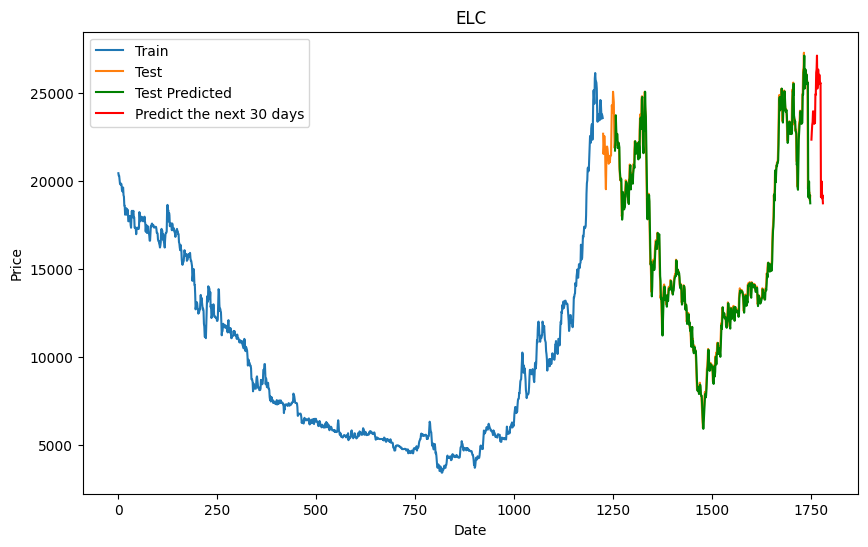

In [12]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict the next 30 days')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ELC')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

16/16 [==============================] - 0s 9ms/step


In [14]:
mape_test *= 100
print("RMSE:", round(rmse_test,3))
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))


RMSE: 585.781
MAPE: 2.454
MAE: 385.307


#8:2

In [15]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.8)
test_size = int(len(scaled_prices) * 0.2)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [16]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(FPT, time_steps):
    X, y = [], []
    for i in range(len(FPT) - time_steps):
        X.append(FPT[i:i+time_steps])
        y.append(FPT[i+time_steps])
    return np.array(X), np.array(y)

In [17]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [18]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
22/22 [==============================] - 5s 25ms/step - loss: 0.0413
Epoch 2/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0020
Epoch 3/100
22/22 [==============================] - 1s 23ms/step - loss: 7.0436e-04
Epoch 4/100
22/22 [==============================] - 0s 21ms/step - loss: 5.7460e-04
Epoch 5/100
22/22 [==============================] - 0s 23ms/step - loss: 5.5445e-04
Epoch 6/100
22/22 [==============================] - 1s 24ms/step - loss: 5.4856e-04
Epoch 7/100
22/22 [==============================] - 1s 25ms/step - loss: 4.9675e-04
Epoch 8/100
22/22 [==============================] - 1s 23ms/step - loss: 5.2521e-04
Epoch 9/100
22/22 [==============================] - 1s 24ms/step - loss: 5.0756e-04
Epoch 10/100
22/22 [==============================] - 1s 23ms/step - loss: 5.6426e-04
Epoch 11/100
22/22 [==============================] - 1s 24ms/step - loss: 5.9911e-04
Epoch 12/100
22/22 [==============================] - 1s 24ms/step - lo

In [21]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(ELC) + 1,len(ELC) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

10/10 [==============================] - 0s 5ms/step
[[1750]
 [1751]
 [1752]
 [1753]
 [1754]
 [1755]
 [1756]
 [1757]
 [1758]
 [1759]
 [1760]
 [1761]
 [1762]
 [1763]
 [1764]
 [1765]
 [1766]
 [1767]
 [1768]
 [1769]
 [1770]
 [1771]
 [1772]
 [1773]
 [1774]
 [1775]
 [1776]
 [1777]
 [1778]
 [1779]]
1/1 [==============================] - 0s 24ms/step
[22441.19  22713.502 23158.566 23170.076 23921.963 23709.096 23406.906
 23038.012 23201.38  23127.477 25074.354 24554.793 26363.207 25961.781
 27177.326 24547.465 25850.826 25972.297 25631.662 25275.56  25955.203
 25299.076 25417.244 25343.523 17883.68  20116.533 19327.002 19041.518
 19153.076 18597.146]


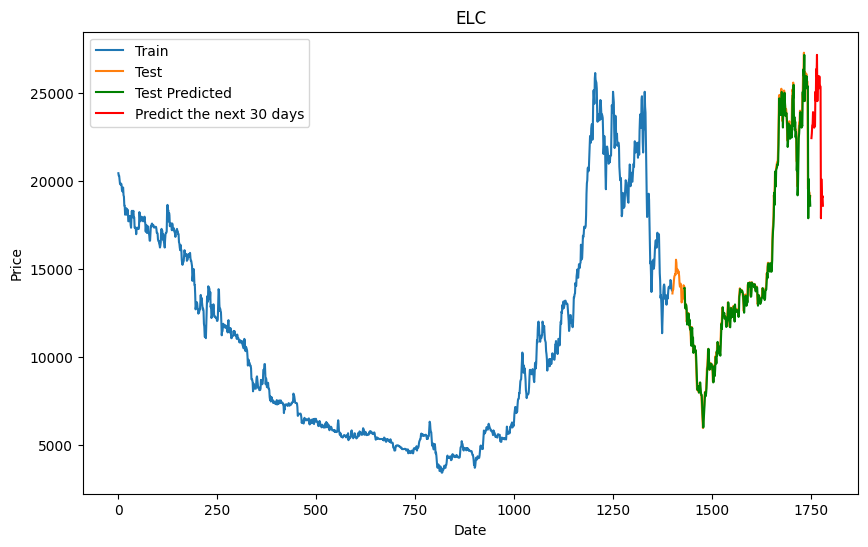

In [22]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict the next 30 days')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ELC')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

10/10 [==============================] - 0s 6ms/step


In [24]:
mape_test *= 100
print("RMSE:", round(rmse_test,3))
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))

RMSE: 591.06
MAPE: 2.449
MAE: 366.409


#9:1

In [25]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.9)
test_size = int(len(scaled_prices) * 0.1)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [26]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(FPT, time_steps):
    X, y = [], []
    for i in range(len(FPT) - time_steps):
        X.append(FPT[i:i+time_steps])
        y.append(FPT[i+time_steps])
    return np.array(X), np.array(y)

In [27]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [28]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [29]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
25/25 [==============================] - 6s 26ms/step - loss: 0.0290
Epoch 2/100
25/25 [==============================] - 1s 25ms/step - loss: 9.9674e-04
Epoch 3/100
25/25 [==============================] - 2s 62ms/step - loss: 5.1935e-04
Epoch 4/100
25/25 [==============================] - 2s 67ms/step - loss: 4.7271e-04
Epoch 5/100
25/25 [==============================] - 2s 63ms/step - loss: 4.5445e-04
Epoch 6/100
25/25 [==============================] - 1s 52ms/step - loss: 4.6123e-04
Epoch 7/100
25/25 [==============================] - 1s 31ms/step - loss: 4.0703e-04
Epoch 8/100
25/25 [==============================] - 1s 34ms/step - loss: 4.0820e-04
Epoch 9/100
25/25 [==============================] - 1s 36ms/step - loss: 3.9119e-04
Epoch 10/100
25/25 [==============================] - 1s 48ms/step - loss: 4.2936e-04
Epoch 11/100
25/25 [==============================] - 2s 68ms/step - loss: 3.8317e-04
Epoch 12/100
25/25 [==============================] - 1s 33ms/step 

In [31]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(ELC) + 1,len(ELC) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

5/5 [==============================] - 0s 5ms/step
[[1750]
 [1751]
 [1752]
 [1753]
 [1754]
 [1755]
 [1756]
 [1757]
 [1758]
 [1759]
 [1760]
 [1761]
 [1762]
 [1763]
 [1764]
 [1765]
 [1766]
 [1767]
 [1768]
 [1769]
 [1770]
 [1771]
 [1772]
 [1773]
 [1774]
 [1775]
 [1776]
 [1777]
 [1778]
 [1779]]
1/1 [==============================] - 0s 24ms/step
[21366.295 21779.479 22168.738 22207.145 23011.729 22725.365 22443.236
 22061.787 22287.266 22179.164 24188.27  23405.715 25459.668 24768.588
 26306.82  23268.703 25076.941 24904.59  24705.613 24199.945 25034.21
 24234.322 24464.889 24314.2   16548.104 19535.225 18425.512 18292.97
 18206.238 17707.004]


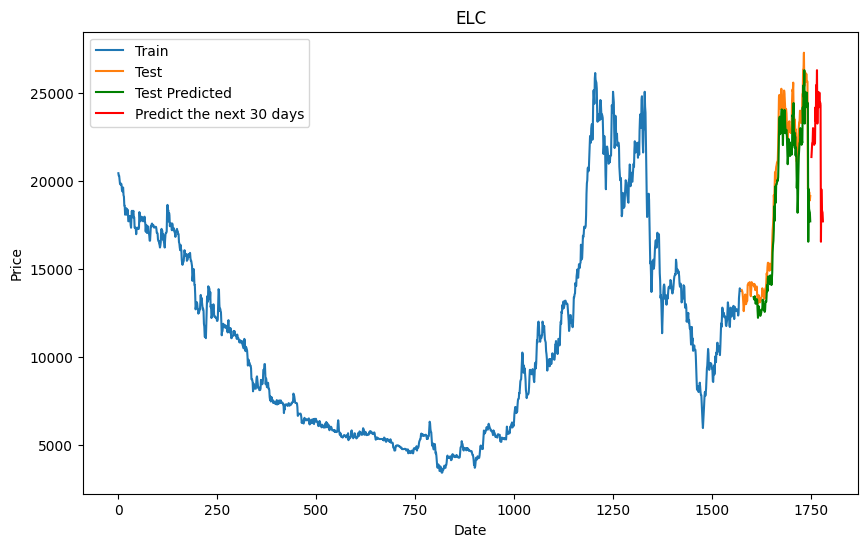

In [32]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict the next 30 days')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ELC')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

5/5 [==============================] - 0s 7ms/step


In [34]:
mape_test *= 100
print("RMSE:", round(rmse_test,3))
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))

RMSE: 1325.171
MAPE: 5.756
MAE: 1153.255
